In [1]:
import soundfile # to read audio file
import numpy as np #multi-dimensional arrays
import librosa # to extract speech features
import glob #to retrieve files/pathnames
import os #provides functions for creating and removing a directory(folder)
import pickle # to save model after training
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score # to measure how good we are

In [2]:
#extract features from soundfile
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
        if contrast:
            contrast=np.mean(librosa.feature.spectral_contrast(S=stft, sr=srate).T,axis=0)
            result=np.hstack((result, contrast))
        if tonnetz:
            tonnetz=np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=srate).T,axis=0)
            result=np.hstack((result, tonnetz))
    return result

In [3]:
#Emotions available in TESS Dataset
emotions={
  'neutral':'NEUTRAL',
  'happy':'HAPPY',
  'sad':'SAD',
  'angry':'ANGRY',
  'fear':'FEARFUL',
  'disgust':'DISGUST',
  'ps':'SURPRISE'
}
#Emotions we want to observe
observed_emotions=['NEUTRAL', 'HAPPY', 'FEARFUL', 'DISGUST']

In [6]:
#load the data
def load_data(test_size=0.25):
    x,y=[],[]
    answer = 0
    for file in glob.glob('E:\Kaggle\Toronto emotion speech set\clean_speech_of_TESS\*.wav'):
        file_name=os.path.basename(file)
        filename=file_name.split("_")[2]
        emotion=emotions[filename.split(".wav")[0]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [7]:
#Split the dataset
#testing data 25%, training data 75%
x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
#mapping of testing data(predicted emotions) with corresponding filenames
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
#print(*test_filename,sep="\n")

(1200, 180) (400, 180) (1200, 2) (400, 2)
(1200,) (400,)


In [8]:
#Get the shape(number of elements) of the training and testing datasets
#print((x_train.shape[0], x_test.shape[0])) (576, 192)
#Get the number of features extacted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [9]:
#Initialise MLPClassifier
model_params = {
    'alpha': 0.01,
    'batch_size': 200,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (600,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}
model = MLPClassifier(**model_params)
#Train the model
print("Training the model...")
model.fit(x_train, y_train)
#Predict values for test set
y_pred = model.predict(x_test)
#Calculate accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Training the model...
Accuracy: 100.00%


In [11]:
#create pkl file to save model
import pickle
Pkl_Filename = "Speech_Emotion_Detection_Model_TESS.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [12]:
#load model from file
with open(Pkl_Filename, 'rb') as file:  
    Speech_Emotion_Detection_Model_TESS = pickle.load(file)

Speech_Emotion_Detection_Model_TESS

MLPClassifier(alpha=0.01, batch_size=200, hidden_layer_sizes=(600,),
              learning_rate='adaptive', max_iter=500)

In [14]:
#Predict values for test set using saved model
y_pred = Speech_Emotion_Detection_Model_TESS.predict(x_test)

In [15]:
#create csv file of filenames with emotions
import numpy as np #multi-dimensional array
import pandas as pd #data analysis
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
#print(y_pred1)
y_pred1.to_csv('TESS_predictionfinal.csv')
y_pred1[:]

,predictions,file_names
0,NEUTRAL,OAF_tell_neutral.wav
1,FEARFUL,YAF_ton_fear.wav
2,NEUTRAL,YAF_third_neutral.wav
3,HAPPY,OAF_tell_happy.wav
4,FEARFUL,OAF_chat_fear.wav
...,...,...
395,HAPPY,YAF_loaf_happy.wav
396,DISGUST,YAF_seize_disgust.wav
397,NEUTRAL,OAF_bite_neutral.wav
398,HAPPY,OAF_hit_happy.wav


In [16]:
#To get Classification Report
from sklearn.metrics import classification_report #Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     DISGUST       1.00      1.00      1.00        90
     FEARFUL       1.00      1.00      1.00       107
       HAPPY       1.00      1.00      1.00       103
     NEUTRAL       1.00      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



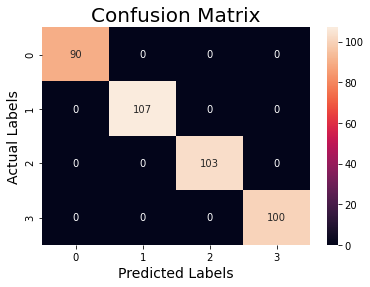

In [17]:
#To Draw Confusion Matrix
from sklearn.metrics import confusion_matrix #Confusion_Matrix
import matplotlib.pyplot as plt #to create a figure & to plot area
import pandas as pd #data analysis
import seaborn as sns #data visualization based on matplotlib
cm=confusion_matrix(y_test,y_pred)
df_cm=pd.DataFrame(cm)
sns.heatmap(df_cm,annot=True,fmt='')
plt.title("Confusion Matrix", size=20)
plt.xlabel("Predicted Labels", size=14)
plt.ylabel("Actual Labels", size=14)
plt.savefig("TESS_Initial_Model_Confusion_Matrix.png")
plt.show()